In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
api_key = '764-Cog1Q3xa6Rns5pmj'
quandl.ApiConfig.api_key = api_key
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [4]:
con, meta = connect('postgres', '', 'robotdb')
    
tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('screen', String, primary_key = True)
                
        
)

macd = Table('Macd', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('ema12', Float),
    Column('ema_26', Float),
    Column('macd_line', Float),
    Column('signal_line', Float),
    Column('histogram', Float),
    Column('screen', Integer, primary_key=True)
)

boillinger = Table('Boillinger', meta,
                       Column('date', DateTime, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('upper_band', Float),
                       Column('lower_band', Float),
                       Column('sma20', Float),
                       Column('height', Float),
                       Column('screen', Integer, primary_key=True)
                       )

ema = Table('Ema', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('ema5', Float),
                Column('ema20', Float),
                Column('ema5_theta', Float),
                Column('ema20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

long_positions = Table('Long', meta,
                       Column('id_position', Integer, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('strategy', String),
                       Column('size_position', Float),
                       Column('date_ask', DateTime),
                       Column('ask', Float),
                       Column('date_settlement', DateTime),
                       Column('settlement', Float),
                       Column('take_profit', Float),
                       Column('stop_loss', Float),
                       Column('exit_date', DateTime),
                       Column('exit_price', Float),
                       Column('log_return', Float),
                       Column('status', String)
                       )


mkt_trend = Table('Market_trend', meta,
                  Column('coin', String, primary_key=True),
                  Column('date', DateTime, primary_key=True),
                  Column('screen', Integer, primary_key=True),
                  Column('dif_current', Float),
                  Column('dif_base', Float),
                  Column('d_dif', Float),
                  Column('theta_current', Float),
                  Column('theta_base', Float),
                  Column('d_theta', Float),
                  Column('vote', Integer)
                  )


rsi = Table('Rsi', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('rsi', Float),
    Column('screen', Integer, primary_key=True)
)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
# Create the above tables
# meta.create_all(con)

In [5]:
def get_macds(coin = None, date = '2018-12-31', screen = 1):
    if coin:
        s = select([macd])\
            .where(and_(macd.c.coin == coin, macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
    else:
         s = select([macd])\
            .where(and_(macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
            
    rows = con.execute(s)
    macd_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not macd_df.empty:
        macd_df.columns = rows.keys()
    return macd_df

def get_tickers(coin = None, date = '2018-12-31', screen = 1):
    if coin:
        s = select([tickers])\
            .where(and_(tickers.c.coin == coin, tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    else:
        s = select([tickers])\
            .where(and_(tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not tickers_df.empty:
        tickers_df.columns = rows.keys()
    return tickers_df

def get_positions(coin=None, status='closed', date='2018-12-31'):
    if coin:
        s = select([long_positions]) \
            .where(and_(long_positions.c.coin == coin,
                        long_positions.c.date_ask <= date,
                        long_positions.c.status == status))\
            .order_by(desc(long_positions.c.date_ask))
    else:
        s = select([long_positions]) \
            .where(and_(long_positions.c.date_ask <= date,
                        long_positions.c.status == status))\
            .order_by(desc(long_positions.c.date_ask))
    rows = con.execute(s)
    long_positions_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not long_positions_df.empty:
        long_positions_df.columns = rows.keys()
    return long_positions_df

def get_emas(coin=None, date='2018-12-31', screen=1):
    if coin:
        s = select([ema])\
            .where(and_(ema.c.coin == coin, ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    else:
        s = select([ema])\
            .where(and_(ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not ema_df.empty:
        ema_df.columns = rows.keys()
    return ema_df

def get_mkt_trend(coin=None, date='2018-12-31', screen=1):
    if coin:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    else:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

In [6]:
# def plot(dfs):
#     c = ['red', 'blue', 'green', 'yellow']
#     fig, ax = plt.subplots()
#     ax.xaxis.set_major_locator(mdates.DayLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %Y %H'))
#     for i in range(len(dfs)):
#         df = dfs[i]
#         ax.plot(df.x, df.y, color = c[i])
#     ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     fig.autofmt_xdate()
#     plt.show()  

# dfs = []
# mkt_trend_df = get_mkt_trend(coin, date, 1)
# df['x'] = mkt_trend_df.date
# df['y'] = mkt_trend_df.dif_current
# dfs.append(df)
# tickers_df = get_tickers(coin, date, 0)
# df['x'] = tickers_df.date
# df['y'] = tickers_df.price
# dfs.append(df)
# long_df = get_positions(coin, 'closed', date)
# df['x'] = long_df.date_ask
# df['y'] = long_df.ask
# dfs.append(df)
# macd_df = get_macds(coin, date, 1)
# df['x'] = macd_df.date
# df['y'] = macd_df.ema_26
# dfs.append(df)
# plot(dfs)

In [7]:
def plot_market_trend(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):
    mkt_trend_df = get_mkt_trend(coin, date, 1)
    
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.HourLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %Y %H'))
    ax.bar(mkt_trend_df.date.values, mkt_trend_df.dif_current.values, color = 'red')
    
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

EXAMPLE OF SAVE

In [8]:
def plot_screen(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):
    tickers_df = get_tickers(coin, date, 0)
    tickers_df = tickers_df[(tickers_df.date < date) & (tickers_df.date > start_date)]
    long_df = get_positions(coin, 'closed', date)
    long_df = long_df[(long_df.date_ask < date) & (long_df.date_ask >= start_date)]
    macd_df = get_macds(coin, date, 1)
    macd_df = macd_df[(macd_df.date < date) & (macd_df.date >= start_date)]
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.HourLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %m %Y %H'))
    ax.plot(tickers_df.date.values, tickers_df.price.values, color = 'green')
    ax.scatter(long_df.date_ask.values, long_df.ask.values, color = 'red')
#     ax.plot(macd_df.date.values, macd_df.ema_26.values, color = 'yellow')
#     ax.scatter(long_df.exit_date.values, long_df.exit_price.values, color = 'blue')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

In [9]:
def plot_screen_2(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):

    macd_df = get_macds(coin, date, 1)
    macd_df = macd_df[(macd_df.date < date) & (macd_df.date >= start_date)]
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.HourLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %m %Y %H'))
    short = ax.plot(macd_df.date.values, macd_df.ema12.values, color = 'blue', label='Short', marker = 'o')
    long = ax.plot(macd_df.date.values, macd_df.ema_26.values, color = 'red', label='Long', marker = 'o')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d H:M:S')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

In [10]:
def plot_screen_3(coin, start_date = datetime.today().strftime('%Y-%m-%d'), date = datetime.today().strftime('%Y-%m-%d')):

    ema_df = get_emas(coin, date, 1)
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.HourLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %m %Y %H'))
    ax.plot(ema_df.date.values, ema_df.ema20.values, color = 'red', label='Long', marker ='o')
    ax.plot(ema_df.date.values, ema_df.ema5.values, color = 'blue', marker = 'o')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d H:M:S')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

In [11]:
def plot_fft(coin, start, date):
    from scipy.fftpack import fft, ifft
    df = get_tickers(coin, date, 1)
    df = df[(df.date < date) & (df.date >= start)]
    time = df.date
    df = get_tickers(coin, date, 1)
    df = df[(df.date < date) & (df.date >= start)]
    time = df.date
    data = df.price
    # N = 4*60*60 # measured every 15 minutes
    yf = fft(data)
    # fig, ax = plt.subplots()
    # ax.plot(2.0/N * np.abs(yf[:N//2]), color = 'red')
    # # ax.set_xlim(0, 100)
    # plt.show() 
    wn = 18
    # yf[20:]=0
    yf[wn:-wn] = 0
    iY = ifft(yf).real
    fig, ax = plt.subplots()
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %m %Y %H'))
    # long = ax.plot(macd_df.date, macd_df.ema12, color = 'blue')
    ax.plot(df.date.values, iY, color = 'red', marker = 'o')
    # ax.plot(df.date.values, df.price, color = 'blue')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d H:M:S')
    fig.autofmt_xdate()
    plt.show()

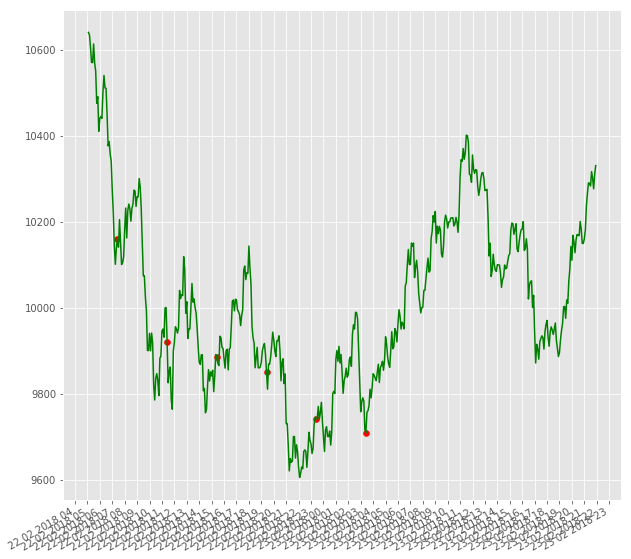

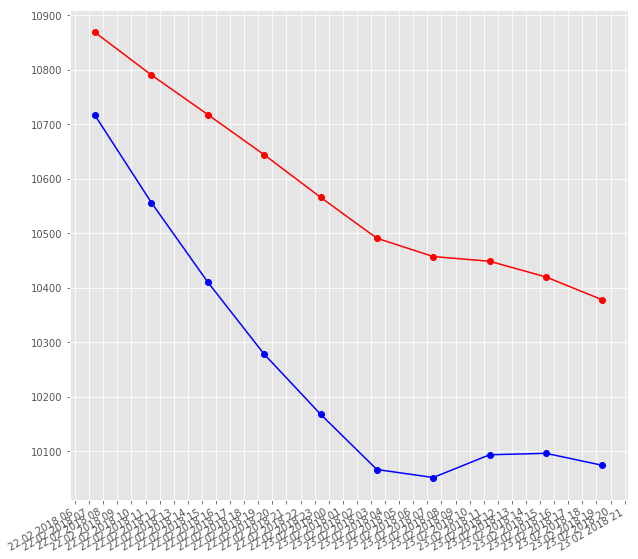

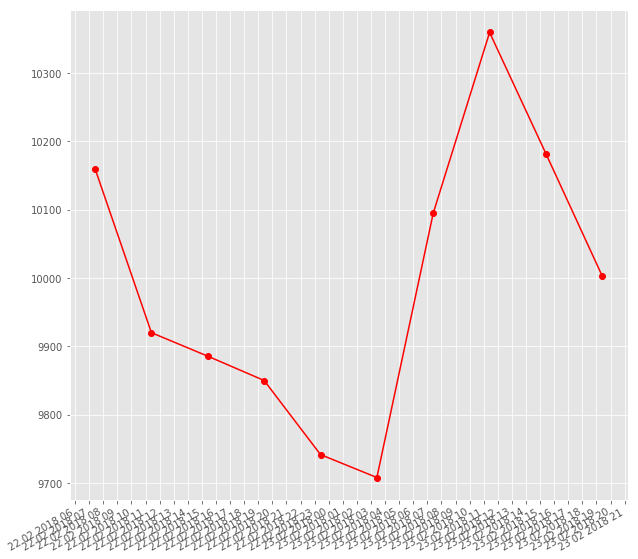

In [12]:
coin = 'USDT_BTC'
start = '2018-02-22 05:00:00'
stop = '2018-02-23 22:00:00'
plot_screen(coin, start, stop)
# stop = '2018-02-22 17:00:00'
plot_screen_2(coin, start, stop)
plot_fft(coin, start, stop)
# plot_screen_3(coin, start, stop)

In [13]:
def log_return(coin=None, date_init = '2017-01-01', date_end = '2018-12-31'):    
    long_df = get_positions(coin, 'closed', date_end)
    mkt_trend_df = get_mkt_trend(coin, date_end, 1)
#     mkt_trend_df = mkt_trend_df[['date', 'screen', 'dif_current', 'delta_dif']] 
    
    merged = pd.merge(long_df, mkt_trend_df, how='inner', left_on=['date_ask'], right_on=['date'])
    merged['real_return'] = np.log((200 * (1 + merged['log_return']))/(200 + 200 * 0.0015 + 200 * (1 + merged['log_return']) * 0.0025))
#     print(merged['real_return'].mean())
#     print(merged['real_return'].max())
#     print(merged['real_return'].min())
#     print((merged['real_return'] * 100).sum())
    merged = merged.drop(['id_position',
                          'size_position',
                          'date_settlement',
                          'settlement', 
                          'status',
                          'date', 
                          'screen'], axis = 1)
    return merged
    
date = '2018-01-01'
date_end = '2018-03-01'
coin = 'USDT_BTC'

# print('DATE')
log_return(None, date, date_end)
print('ALL')
df = log_return()
df

ALL


coin_x strategy            date_ask           ask   take_profit  \
0    USDT_BTC  CHANNEL 2017-06-07 18:25:00   2635.000000   3030.250000   
1    USDT_LTC  CHANNEL 2017-06-07 19:20:00     27.833830     32.008904   
2    USDT_LTC  CHANNEL 2017-06-08 07:20:00     29.075828     33.310523   
3    USDT_LTC  CHANNEL 2017-06-08 11:20:00     28.470216     32.740748   
4    USDT_BTC  CHANNEL 2017-06-10 06:25:00   2810.092500   3180.782849   
5    USDT_LTC  CHANNEL 2017-06-10 11:20:00     29.630000     33.752410   
6    USDT_LTC  CHANNEL 2017-06-10 15:20:00     28.847819     33.174991   
7    USDT_BTC  CHANNEL 2017-06-11 02:25:00   2800.000000   3199.714424   
8    USDT_BTC  CHANNEL 2017-06-12 06:25:00   2820.000000   3243.000000   
9    USDT_BTC  CHANNEL 2017-06-12 10:25:00   2672.934000   3073.874100   
10   USDT_LTC  CHANNEL 2017-06-12 19:20:00     27.000000     31.050000   
11   USDT_BTC  CHANNEL 2017-06-12 22:25:00   2643.750570   3040.313156   
12   USDT_LTC  CHANNEL 2017-06-12 23:20:00     27.710000     31.866500   
13   USDT_BTC  CHANNEL 2017-06-13 02:25:00   2597.385049   2986.992807   
14   USDT_LTC  CHANNEL 2017-06-13 03:20:00     28.370000     32.625500   
15   USDT_BTC  CHANNEL 2017-06-13 06:25:00   2670.512327   3071.089176   
16   USDT_LTC  CHANNEL 2017-06-13 07:20:00     28.291414     32.535127   
17   USDT_BTC  CHANNEL 2017-06-14 10:25:00   2525.000000   2903.750000   
18   USDT_BTC  CHANNEL 2017-06-14 22:25:00   2437.369878   2802.975360   
19   USDT_BTC  CHANNEL 2017-06-15 02:25:00   2276.000000   2617.400000   
20   USDT_BTC  CHANNEL 2017-06-15 06:25:00   2356.562797   2710.047217   
21   USDT_BTC  CHANNEL 2017-06-18 18:25:00   2486.390035   2851.664622   
22   USDT_BTC  CHANNEL 2017-06-25 02:25:00   2532.061773   2911.871039   
23   USDT_BTC  CHANNEL 2017-06-25 06:25:00   2552.614335   2935.506485   
24   USDT_BTC  CHANNEL 2017-06-25 14:25:00   2534.900000   2915.135000   
25   USDT_BTC  CHANNEL 2017-06-26 10:25:00   2426.000000   2789.900000   
26   USDT_BTC  CHANNEL 2017-06-26 14:25:00   2358.000000   2711.700000   
27   USDT_BTC  CHANNEL 2017-06-26 18:25:00   2363.000000   2717.450000   
28   USDT_BTC  CHANNEL 2017-06-27 06:25:00   2322.528752   2670.908065   
29   USDT_BTC  CHANNEL 2017-06-27 10:25:00   2306.439000   2652.404850   
..        ...      ...                 ...           ...           ...   
283  USDT_BTC  CHANNEL 2018-02-21 19:25:00  10322.561390  11870.945598   
284  USDT_LTC  CHANNEL 2018-02-21 20:20:00    211.034917    242.690155   
285  USDT_BTC  CHANNEL 2018-02-21 23:25:00  10719.288204  12327.181434   
286  USDT_LTC  CHANNEL 2018-02-22 00:20:00    216.100000    248.515000   
287  USDT_LTC  CHANNEL 2018-02-22 04:20:00    213.642000    245.688300   
288  USDT_BTC  CHANNEL 2018-02-22 07:25:00  10160.000000  11684.000000   
289  USDT_LTC  CHANNEL 2018-02-22 08:20:00    205.100568    235.865653   
290  USDT_BTC  CHANNEL 2018-02-22 11:25:00   9920.000000  11408.000000   
291  USDT_LTC  CHANNEL 2018-02-22 12:20:00    196.134000    225.554100   
292  USDT_BTC  CHANNEL 2018-02-22 15:25:00   9885.597026  11368.436580   
293  USDT_LTC  CHANNEL 2018-02-22 16:20:00    192.100001    220.915001   
294  USDT_BTC  CHANNEL 2018-02-22 19:25:00   9850.000000  11327.500000   
295  USDT_LTC  CHANNEL 2018-02-22 20:20:00    194.424073    223.587684   
296  USDT_BTC  CHANNEL 2018-02-22 23:25:00   9741.568900  11202.804235   
297  USDT_LTC  CHANNEL 2018-02-23 00:20:00    186.162583    214.086970   
298  USDT_BTC  CHANNEL 2018-02-23 03:25:00   9707.999999  11164.199999   
299  USDT_LTC  CHANNEL 2018-02-23 04:20:00    193.526125    222.555043   
300  USDT_BTC  CHANNEL 2018-02-25 11:25:00   9490.250976  10913.788623   
301  USDT_BTC  CHANNEL 2018-02-25 15:25:00   9314.289720  10711.433177   
302  USDT_BTC  CHANNEL 2018-02-25 19:25:00   9544.942258  10976.683597   
303  USDT_LTC  CHANNEL 2018-02-27 12:20:00    215.500000    246.289135   
304  USDT_LTC  CHANNEL 2018-02-27 16:20:00    215.799985    246.530475   
305  USDT_L

In [14]:
# date = '2017-01-01'
# date_end = '2018-12-31'
# coin = 'USDT_BTC'
# long_df = get_positions(coin, 'closed', date_end)
# mkt_trend_df = get_mkt_trend(coin, date_end, 1)
# mkt_trend_df['delta_dif'] = mkt_trend_df['delta_dif']
# mkt_trend_df = mkt_trend_df[['date', 'screen', 'dif_current', 'delta_dif']] 
# merged = pd.merge(long_df, mkt_trend_df, how='inner', left_on=['date_ask'], right_on=['date'])
    
# mkt_trend_df.describe()

In [15]:
# fig, ax = plt.subplots()
# ax.hist(mkt_trend_df.dropna().delta_dif, color = 'blue', bins = 45)
# plt.show()

## 

In [16]:
date = '2017-01-01'
date_end = '2018-12-31'
coin = 'USDT_BTC'

long_df = get_positions(status='closed', date=date_end)
mkt_trend_df = get_mkt_trend(date=date_end, screen=1)
mkt_trend_df = mkt_trend_df[['date', 'screen', 'dif_current', 'd_dif']] 
merged = pd.merge(long_df, mkt_trend_df, how='inner', left_on=['date_ask'], right_on=['date'])
merged['real_return'] = np.log((200 * (1 + merged['log_return']))/(200 + 200 * 0.0015 + 200 * (1 + merged['log_return']) * 0.0025))
merged['month'] = pd.to_datetime(merged['date_ask']).dt.month
merged['year'] = pd.to_datetime(merged['date_ask']).dt.year

In [17]:
merged.groupby(['coin', 'strategy', 'year','month'])['log_return', 'real_return'].mean()

log_return  real_return
coin     strategy year month                         
USDT_BTC CHANNEL  2017 6       -0.023970    -0.028954
                       7       -0.002944    -0.008160
                       9        0.000868    -0.004119
                       10       0.141165     0.127706
                  2018 1       -0.012900    -0.018630
                       2        0.008047     0.002065
USDT_LTC CHANNEL  2017 6        0.043342     0.036906
                       8        0.092073     0.081318
                       9        0.005334     0.000875
                       10      -0.023499    -0.028192
                       11       0.018603     0.010272
                  2018 1       -0.025542    -0.030213
                       2       -0.010564    -0.016014
                       3        0.021097     0.016819

In [18]:
merged.groupby(['strategy', 'year','month'])['log_return', 'real_return'].mean()

log_return  real_return
strategy year month                         
CHANNEL  2017 6       -0.004428    -0.009833
              7       -0.002944    -0.008160
              8        0.092073     0.081318
              9        0.003101    -0.001622
              10      -0.004127    -0.009851
              11       0.018603     0.010272
         2018 1       -0.017114    -0.022491
              2       -0.000071    -0.005821
              3        0.021097     0.016819

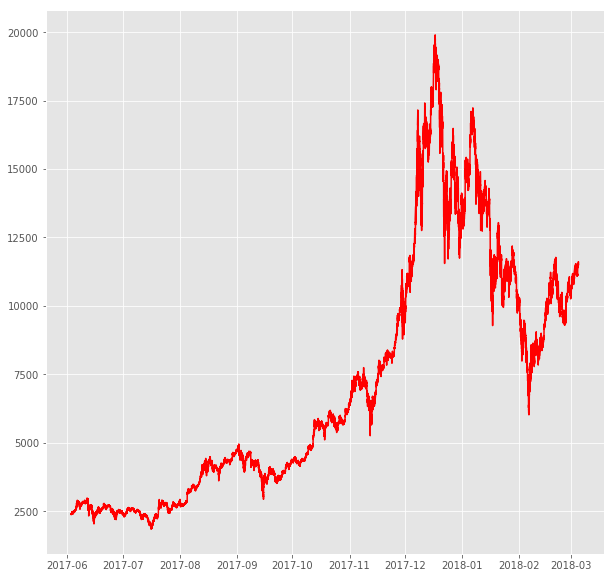

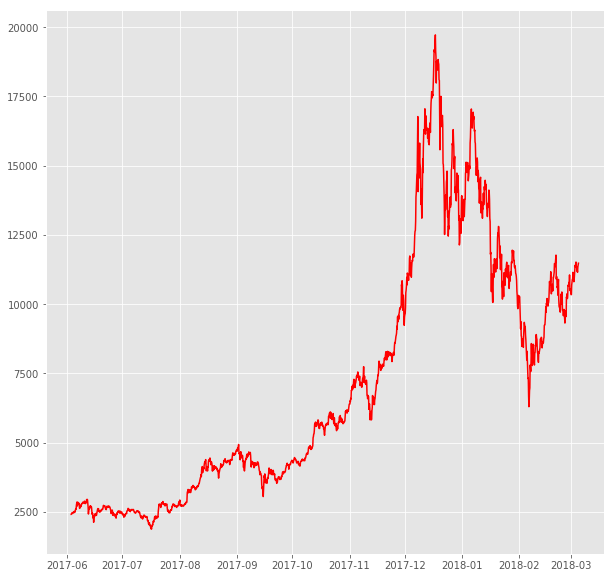

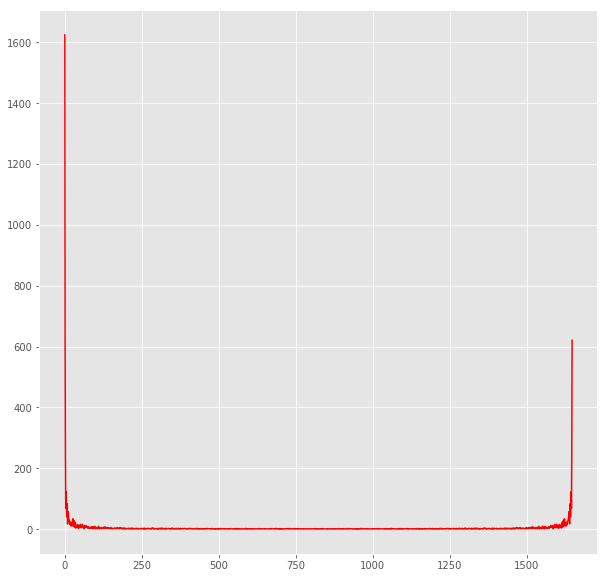

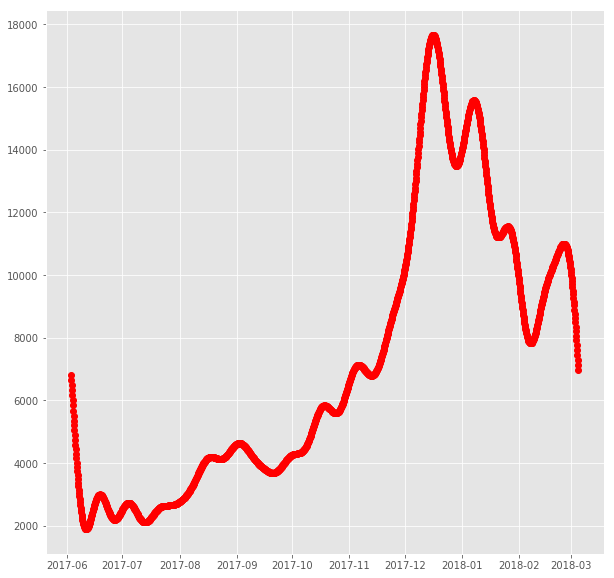

In [19]:
import numpy as np
import scipy
coin = 'USDT_BTC'
date = '2019-01-18'
start = '2017-01-15'
df = get_tickers(coin, date, 0)
df = df[(df.date < date) & (df.date >= start)]
time = df.date
fig, ax = plt.subplots()
ax.plot(df.date, df.price, color = 'red')
plt.show()
df = get_tickers(coin, date, 1)
df = df[(df.date < date) & (df.date >= start)]
time = df.date
fig, ax = plt.subplots()
ax.plot(df.date, df.price, color = 'red')
plt.show()
data = df.price
N = 4*60*60 # measured every 15 minutes
yf = scipy.fftpack.fft(data)
fig, ax = plt.subplots()
ax.plot(2.0/N * np.abs(yf[:N//2]), color = 'red')
# ax.set_xlim(0, 100)
plt.show() 
wn = 18
# yf[20:]=0
yf[wn:-wn] = 0
iY = scipy.fftpack.ifft(yf).real
fig, ax = plt.subplots()
# long = ax.plot(macd_df.date, macd_df.ema12, color = 'blue')
ax.plot(df.date.values, iY, color = 'red', marker = 'o')
# ax.plot(df.date.values, df.price, color = 'blue')
plt.show()